<a href="https://colab.research.google.com/github/Arindam75/graph_networks/blob/main/04_node_classification_cora_gcn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Practice Code](https://github.com/PacktPublishing/Hands-On-Graph-Neural-Networks-Using-Python/blob/main)

Github page for the textbook Hands on GNNs Using Python by Maxime Labonne

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.6 MB/s eta 0:00:00


In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Load Data
Basic information about the data

In [ ]:
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

Processing...
Done!


The degrees array contains the degree of each node.

In [ ]:
degrees =degree(data.edge_index[0]).cpu().numpy()
degrees.shape

(2708,)

Text(0.5, 1.0, 'Degree distribution')

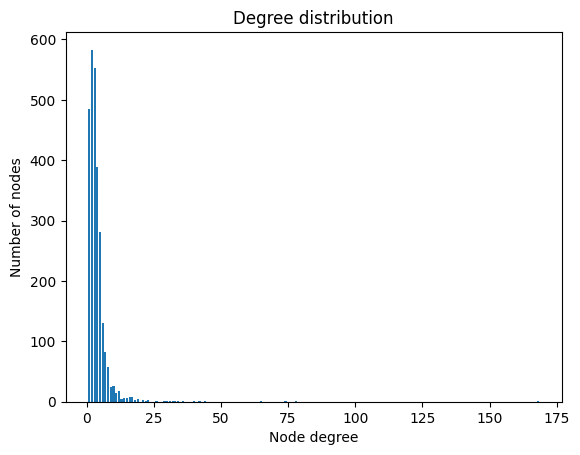

In [ ]:
deg_counts = Counter(degrees)
fig, ax = plt.subplots()
ax.bar(deg_counts.keys(), deg_counts.values())
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
ax.set_title("Degree distribution")

In [ ]:
print(f'dataset {dataset}: {data.num_nodes} nodes, {data.num_edges} edges')
print(f'node feature shape: {data.x.shape}')
print(f'Number of features {data.num_node_features}')
print(f'Number of classes {data.y.max().item() + 1}')
print(f'class labels: {data.y.unique()}')

dataset Cora(): 2708 nodes, 10556 edges
node feature shape: torch.Size([2708, 1433])
Number of features 1433
Number of classes 7
class labels: tensor([0, 1, 2, 3, 4, 5, 6])


In [ ]:
print(f'Graph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


## GCN Layer

In [ ]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

In [ ]:
def accuracy(y_pred, y_true):

    return torch.sum(y_pred == y_true) / len(y_true)

class GCN(torch.nn.Module):

  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    torch.manual_seed(12345)

    self.conv1 = GCNConv(dim_in, dim_h)
    self.conv2 = GCNConv(dim_h, dim_out)

  def forward(self, x, edge_index):

    h = self.conv1(x, edge_index)
    h = torch.relu(h)
    h = self.conv2(h, edge_index)
    return F.log_softmax(h, dim =1)

  def fit(self, data, epochs):

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.parameters(),
                                 lr=0.01,
                                 weight_decay=5e-4)
    self.train()
    for epoch in range(epochs):
      optimizer.zero_grad()
      out = self.forward(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
      loss.backward()
      optimizer.step()

      if epoch%20 == 0:
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

  @torch.no_grad()
  def test(self, data):
    self.eval()
    out = self.forward(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [ ]:
model = GCN(data.num_node_features, 128, dataset.num_classes)
print(model)


GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 7)
)


In [ ]:
model.fit(data, epochs=100)

Epoch   0 | Train Loss: 1.956 | Train Acc: 10.71% | Val Loss: 1.96 | Val Acc: 11.80%
Epoch  20 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.88 | Val Acc: 77.60%
Epoch  40 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 0.76 | Val Acc: 79.00%
Epoch  60 | Train Loss: 0.010 | Train Acc: 100.00% | Val Loss: 0.73 | Val Acc: 77.80%
Epoch  80 | Train Loss: 0.009 | Train Acc: 100.00% | Val Loss: 0.73 | Val Acc: 77.20%


In [ ]:
acc = model.test(data)
print(f'GCN test accuracy: {acc*100:.2f}%')

GCN test accuracy: 80.80%
